# Code for 1976 NFL Season Data Linear Regression & Analysis

In [124]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

Variables will be standardized to aid in the subsequent interpretation of coefficients. OLS can easily handle unscaled predictors, however not scaling these parameters could impact regularization approachs like Lasso or Ridge regression, and it also makes interpreting and comparing the magnitude of coefficients in the model much more difficult. A standard scaler is used here to remove the mean fro meach predictor and scale to unit variance. This is an attractive option for our dataset given the uneven scales (percentages, differentials and large continuous variables) and the ability to observe how unit changes in a predictor's standard deviation impacts winning games. The response variable y will remain unscaled here to maintain our desired output of wins.

In [6]:
# Load the dataset
df = pd.read_excel("NFL_1976_Team_Performance.xlsx")

# Set proper headers (first row is actual header)
df.columns = df.iloc[0]
df = df.drop(index=0).reset_index(drop=True)

# Convert numeric columns to float
for col in df.columns:
    if col != "Team":
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Split into X (predictors) and y (response)
X = df.loc[:, df.columns.str.startswith("x")]
y = pd.to_numeric(df["y"], errors='coerce')

# Standardize X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for easier inspection
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Optional: Merge back for modeling
df_scaled = pd.concat([df[["Team"]], y, X_scaled_df], axis=1)

# Show a preview
print(df_scaled.head())

          Team   y        x1        x2        x3        x4        x5  \
0   Washington  10  0.007355 -0.290161  0.133853  0.509429  0.390493   
1    Minnesota  11 -0.283065  1.484906  0.082512  0.182625  0.292870   
2  New England  11  2.235670 -0.796157  0.749941  0.057671  1.366725   
3      Oakland  13  0.461466  1.586922  1.520052 -1.355273 -0.390493   
4   Pittsburgh  10  2.272632 -0.941019  0.287875 -0.538264  1.464348   

         x6        x7        x8        x9  
0  0.649540  0.291519  0.268505 -0.724101  
1 -1.453450 -0.596534 -0.034893 -1.898559  
2  1.031902  1.406309 -0.727974  0.161893  
3  1.389327  0.612730 -0.572101  1.195552  
4  0.383549  1.500783 -1.813524 -0.899240  


### Null Model Specification

In [15]:
# Add intercept
X_scaled_with_intercept = sm.add_constant(X_scaled_df)

# Fit OLS model
model = sm.OLS(y, X_scaled_with_intercept).fit()

# View full model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     8.839
Date:                Sun, 03 Aug 2025   Prob (F-statistic):           5.33e-05
Time:                        13:28:36   Log-Likelihood:                -50.477
No. Observations:                  28   AIC:                             121.0
Df Residuals:                      18   BIC:                             134.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.9643      0.346     20.129      0.0

Our null model yields an R-squared of 0.815 and an Adjusted R-squared of 0.723. We're explaining a large portion of the variance in our model, but the drop in adjusted R-squared suggests we may have some redundant or unexplanatory variables still in our model. The F-Statistic of 8.839 and corresponding p-value of 5.33e-05 suggest our model is certainly significant, and predictive as a whole. An initial glance at the coefficients tells us that x5, x8 and x9 contain negative effects. x2 is the only variable with a p value less than our 0.05 threshold, however x8 and x9 appear boardline significant as well. 

It's clear that we will need to perform some level of variable selection, but first it will be worthwhile to check variance inflation factors as a guage of multicollinearity present in our predictors. This is important to consider since our feature selection process is naive to multicollinearity across variables. VIF values greater than 5-10 will imply that a variable may be worth removing or combining with another predictor. 

In [22]:
# X_scaled_df is your standardized predictor DataFrame (without intercept)
vif_data = pd.DataFrame()
vif_data["feature"] = X_scaled_df.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled_df.values, i) for i in range(X_scaled_df.shape[1])]

print(vif_data)

  feature       VIF
0      x1  4.814532
1      x2  1.413644
2      x3  2.141417
3      x4  1.566738
4      x5  1.922913
5      x6  1.275302
6      x7  5.362643
7      x8  4.447482
8      x9  1.425342


The only VIF value above 5 is our x7 variable corresponding to percent rushing (rushing plays / total plays). Logically it may make sense that this would share predictive power with overall team rushing yards. We'll keep x7 in our feature selection process as a VIF value of 5.36 is not concerning enough to justify full removal. Overall, there are not any glaring signs of multicollinearity as a result of our VIF test, so we can now proceed to feature selection. 

The stepwise regression function below operates as follows. The selected variable list is empty to begin with. Of the remaining available predictors, the one with the most statistically significant p value less than the defined threshold is added to the model. Next, the variables in the model are assessed for their p-values, and any that fall below the removal threshold are removed. The addition and removal steps are then repeated until no new variables qualify for addition into the model, and all selected variables do not qualify for removal from the model. FInally, a list of selected variables is returned. 

In [31]:
# Stepwise feature selection function ===
def stepwise_selection(X, y, threshold_in=0.05, threshold_out=0.10, verbose=True):
    included = []
    while True:
        changed = False

        # Forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype=float)
        for new_col in excluded:
            model = sm.OLS(y, sm.add_constant(X[included + [new_col]])).fit()
            new_pval[new_col] = model.pvalues[new_col]
        if not new_pval.empty:
            best_pval = new_pval.min()
            if best_pval < threshold_in:
                best_feature = new_pval.idxmin()
                included.append(best_feature)
                changed = True
                if verbose:
                    print(f"Add   {best_feature:8} with p-value {best_pval:.6f}")

        # Backward step
        if included:
            model = sm.OLS(y, sm.add_constant(X[included])).fit()
            pvals = model.pvalues.iloc[1:]  # exclude intercept
            worst_pval = pvals.max()
            if worst_pval > threshold_out:
                worst_feature = pvals.idxmax()
                included.remove(worst_feature)
                changed = True
                if verbose:
                    print(f"Drop  {worst_feature:8} with p-value {worst_pval:.6f}")

        if not changed:
            break
    return included

# Run it
threshold_in = 0.20
threshold_out = 0.30

selected_features = stepwise_selection(X_scaled_df, y, 
                                       threshold_in=threshold_in, 
                                       threshold_out=threshold_out, 
                                       verbose=True)

print("\nFinal selected variables:", selected_features)

Add   x8       with p-value 0.000008
Add   x2       with p-value 0.000192
Add   x7       with p-value 0.031347

Final selected variables: ['x8', 'x2', 'x7']


Based on the selection criteria of p < 0.20 for addition into the model, and p > 0.30 for removal from the model, variables x2 (Passing yards (season)), x7 (Percent rushing plays) and x8 (Opponents rushing yards (season)) were selected for the model. The two threshold values were adjusted for various iterations between values of 0.05 and 0.40, and the final values of 0.20 and 0.30 were chosen as they yielded a small subset of variables that possess strong predictive power, both in terms of p-value and in terms of anectodal and personal experience regarding what features impact winning in the NFL. We hypothsized that variables x1 and x7 may share multicollinearity due to the shared rushing yard characteristic, so the fact that only one of these variables is included in our model is reassuring from a multicollinearity perspective. 

### Subset Model Performance

In [37]:
selected_X = X_scaled_df[['x2', 'x7', 'x8']]

# Add intercept
X_subset_with_const = sm.add_constant(selected_X)

# Fit the model
subset_model = sm.OLS(y, X_subset_with_const).fit()

# Print model summary
print(subset_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     29.35
Date:                Sun, 03 Aug 2025   Prob (F-statistic):           3.36e-08
Time:                        14:37:40   Log-Likelihood:                -52.564
No. Observations:                  28   AIC:                             113.1
Df Residuals:                      24   BIC:                             118.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.9643      0.323     21.574      0.0

Our subset model has an R-squared value of 0.786, slightly down from the null model's 0.815. However, the adjusted R-squared is 0.759, an increase from the 0.723 in the null model. We've increased the predictive power of our model while removing 6 variables, an important boost in model simplicity. Additionally, all three variables are statistically significant at the alpha = 0.05 level. Predictors x2 and x7 are positive effects, and both do not have zero in their confidence intervals meaning we can be confident in their signs. The same is true for x8, although it is clear Opponent rushing yards is a negative effects variable. AIC of our subset model is 113.1, a decrease from our null model's 121.0 value. Our F statistic and corresponding model p-value are 29.35 and 3.36e-08 respectively, indicating strong statistical significance. 

As strong as our subset model looks, it's important to consider the model diagnostics to ensure our key assumptions are holding up. We will now build residual plots, normality plots, constant variance assessments and box-cox measurements. These steps are required to have confidence that our model is properly defined, and to ensure no transformations are required for our predictor variables. 

### Model Diagnostics

In [51]:
# Extract values needed for plotting
fitted_vals = subset_model.fittedvalues
residuals = subset_model.resid
standardized_residuals = subset_model.get_influence().resid_studentized_internal
leverage = subset_model.get_influence().hat_matrix_diag
cooks_d = subset_model.get_influence().cooks_distance[0]

#### Residuals vs Fitted Values Plot

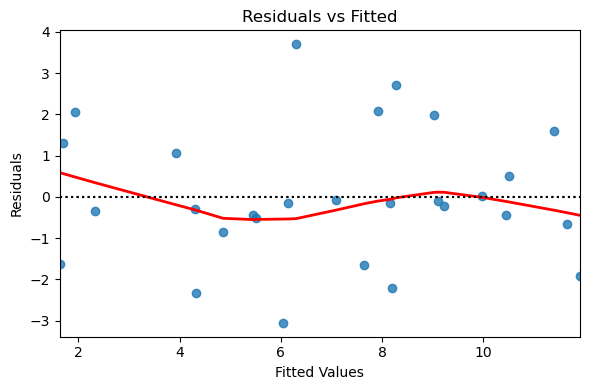

In [53]:
plt.figure(figsize=(6, 4))
sns.residplot(x=fitted_vals, y=residuals, lowess=True, 
              line_kws={'color': 'red', 'lw': 2})
plt.axhline(0, color='black', linestyle='dotted')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.tight_layout()
plt.show()

Here we are plotting the predicted fitted values of the response variable against the raw residuals (observed - predicted). The red line that I included is the LOWESS smoother which is useful in condensing the residual trend into something more digestible. In general, the residuals are reasonably centered around zero with no strong or obvious skew in distribution. There is also no evidence of fanning, suggesting that we are not in the presence of heteroskedasticity. The LOWESS line is slightly wavy which suggests there may be some nonlinearity present around fitted values 5 - 8, which is important to keep in mind depending on how this model will be used. There also appear to be some large residuals around +/- 3 in magnitude. We will keep these points in mind as we evaluate the Cook's distance plot later on in this section. 

#### Normal Plot

<Figure size 600x400 with 0 Axes>

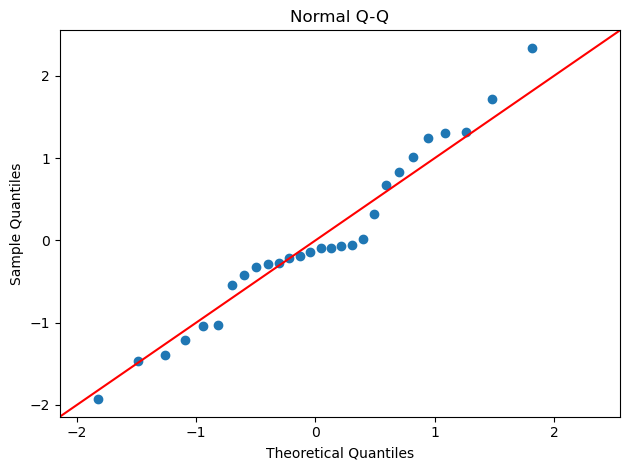

In [57]:
plt.figure(figsize=(6, 4))
sm.qqplot(residuals, line='45', fit=True)
plt.title("Normal Q-Q")
plt.tight_layout()
plt.show()

The normal Q-Q plot is a diagnostic plot for evaluating whether the model residuals are approximately normally distributed, which is one of our key underlying OLS assumptions, especially for inference. The x-axis provides the theoretical quantiles, in other words what our residuals should look like if they were perfectly normal. The y-axis provides what the model residuals actually look like. We can see that the vast majority of the residuals do fall slightly below or slightly above this ideal read line down the center, which supports the validity of our statistical inference capabilities. There is a slight upward bend in the right tail of the residual plot, corresponding to a few large residual values that we already noted in our residuals graph. There is also some flattening present near the zero quantile, indicating less variability than expected. This is relatively minor and can be deemed acceptible given the large number of n (28) we are working with. 

#### Residuals vs Leverage Plot

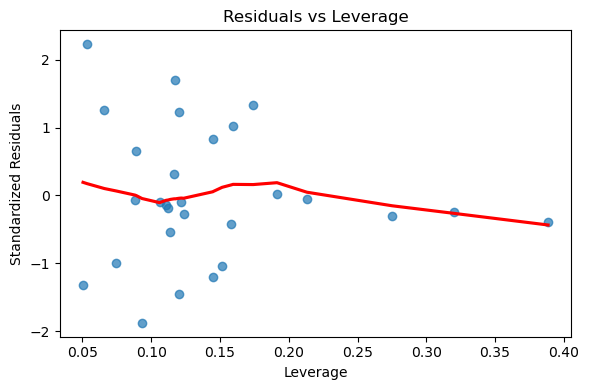

In [63]:
plt.figure(figsize=(6, 4))
plt.scatter(leverage, standardized_residuals, alpha=0.7)
sns.regplot(x=leverage, y=standardized_residuals,
            scatter=False, lowess=True, line_kws={'color': 'red'})
plt.xlabel("Leverage")
plt.ylabel("Standardized Residuals")
plt.title("Residuals vs Leverage")
plt.tight_layout()
plt.show()

The residuals vs leverage plot is an important diagnostic for determining influential observations and overall model stability. The x-axis quantifies how impactful a datapoint is in terms of the overall model coefficients. The y-axis simply shows how far off the model prediction was in standard deviations. Again we leverage the LOWESS smoother to help visualize the overall pattern. The most dangerous combination we are looking for here are points that have both high residual values and high leverage, which would indicate a single datapoint is controlling a large portion of the model definition. We do not observe that here, however there are a couple observations with high leverage > 0.30 that should be watched closely. Overall, most residuals fall between +/- 2, and the majority of leverage points are below 0.25. While there is not cause for concern, the top three leverage points do appear to be pulling our LOWESS smoother downward. Let's identify these points. 

#### Cook's Distance Plot

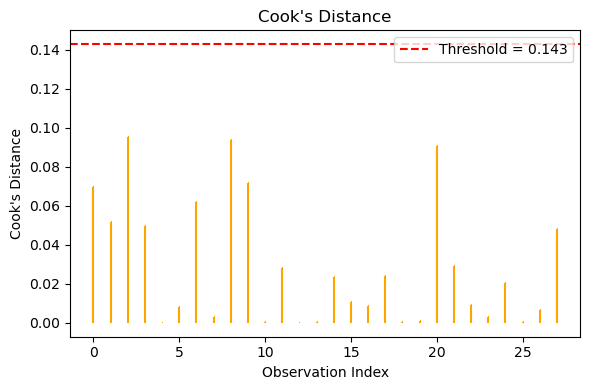

In [75]:
threshold = 4 / len(cooks_d)  # or use 1.0 if you want to be stricter

plt.figure(figsize=(6, 4))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",", basefmt=" ", linefmt="orange")
plt.axhline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.3f}')
plt.title("Cook's Distance")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.legend()
plt.tight_layout()
plt.show()

The Cook's Distance plot is another method of assessing influence of individual observations within the model. The x-axis indicates the observation index, or row number of the dataset, and the y-axis provides the calculated Cook's Distance. As a rule of thumb, the threshold for identifying onfluential points is a distance of 4/n, or in this case 0.143. None of the observations exceed the threshold of 0.143, so we can conclude that no single observation is disproportionately influencing the regression model. There are three or so points that contribute significantly, but in the context of our residual and leverage plots, we can conclude that our model is likely robust to individual data points. 

#### Externally Studentized Residuals plot

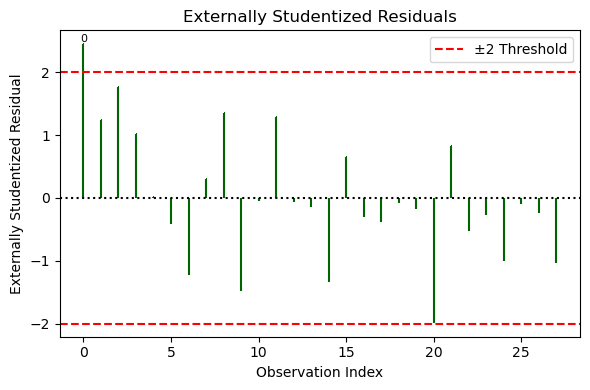

In [98]:
# Externally studentized residuals (useful for formal outlier testing)
external_resid = subset_model.get_influence().resid_studentized_external

plt.figure(figsize=(6, 4))
plt.stem(np.arange(len(external_resid)), external_resid,
         markerfmt=",", basefmt=" ", linefmt="darkgreen")
plt.axhline(0, color='black', linestyle='dotted')
plt.axhline(2, color='red', linestyle='--', label='±2 Threshold')
plt.axhline(-2, color='red', linestyle='--')

# Label outliers
for i, val in enumerate(external_resid):
    if np.abs(val) > 2:
        plt.text(i, val, f'{i}', ha='center', va='bottom', fontsize=8)

plt.title("Externally Studentized Residuals")
plt.xlabel("Observation Index")
plt.ylabel("Externally Studentized Residual")
plt.legend()
plt.tight_layout()
plt.show()

#### High Leverage Points

In [91]:
# Calculate leverage (hat values)
leverage = subset_model.get_influence().hat_matrix_diag

# Define thresholds
avg_leverage = (X_subset_with_const.shape[1]) / X_subset_with_const.shape[0]
high_leverage_threshold = 2 * avg_leverage

# Find high-leverage points
leverage_df = pd.DataFrame({
    "Team": df["Team"],
    "Leverage": leverage,
    "High_Leverage": leverage > high_leverage_threshold
})

# Show high leverage observations
high_leverage_points = leverage_df[leverage_df["High_Leverage"] == True]
high_leverage_points.sort_values(by="Leverage", ascending=False)


,Team,Leverage,High_Leverage
17,Kansas City,0.388536,True
26,Seattle,0.320298,True


We see the two rows corresponding to Kansas City and Seattle are responsible for the highest leverage, with "high" being defined as > 2x the average leverage. These two observations will be watched closely as we proceed to our Cook's Distance veluations. 

#### Large Residual Points

In [95]:
# Get residuals from the model
residuals = subset_model.resid

# Identify observations with residuals > |3|
outlier_mask = np.abs(residuals) > 3
outliers = df[outlier_mask]

# Show relevant info for context
outliers_with_resid = df.loc[outlier_mask].copy()
outliers_with_resid["Residual"] = residuals[outlier_mask]

# Sort by absolute residual (optional)
outliers_with_resid = outliers_with_resid.reindex(outliers_with_resid["Residual"].abs().sort_values(ascending=False).index)

print(outliers_with_resid)

0              Team   y    x1    x2    x3     x4  x5   x6     x7    x8    x9  \
0        Washington  10  2113  1985  38.9  0.647   4  868  0.597  2205  1917   
20  New York Giants   3  1904  1792  39.7  0.381  -9  734  0.619  2203  1988   

0   Residual  
0   3.699712  
20 -3.051523  


The two rows responsible for the largest residuals are Washington and New York giants. We will keep a close eye on these two observations as we evaluate Cook's Distance, leverage and eternally studentized residual plots as they will help provide context towards how these observations are impacting our model. 

#### Externally Studentized Residual Commentary

The externally studentized residual plot builds on our existing residuals plot by excluding the obseration corresponding to the residual in the model fitting process. By doing this, we avoid artificially influencing our own error estimate, which makes externally studentized residuals more reliable for identifying genuine outliers. The two dashed lines represent 2 standard deviations, or in other words observations that would be significant outliers at an alpha level of 0.95. The only observation lying outside of this range is the Washington observation, which was also flagged in the standard residual plot. Because this point did not also arise in the leverage or Cook's Distance plot, it will simply be flagged and left in the model.  

## Model Validation Stage

Bootstrap sampling enables us to build a distribution of possible coefficient values for our model, expanding our understanding of the variability we can expect as well as the model stability we currently have. We randomly resample our 28 observation dataset n times (1000 in this case) to simulate what would happen to the dataset if it had been drawn differently from the same popualtion. From there, we fit a linear model in the same form as our subset model for each of the n bootstrap samples, and we calculate the r-squared and coefficient estimates. From here we can re-calculate 95% confidence intervals and view distributions of each model parameter to gauge the stability and generalizability of our model. 

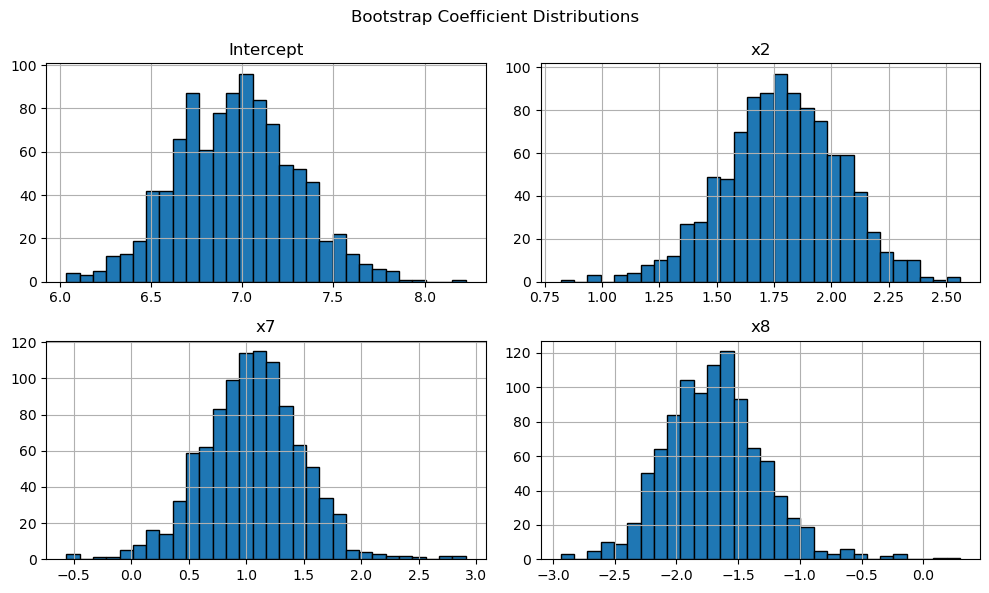

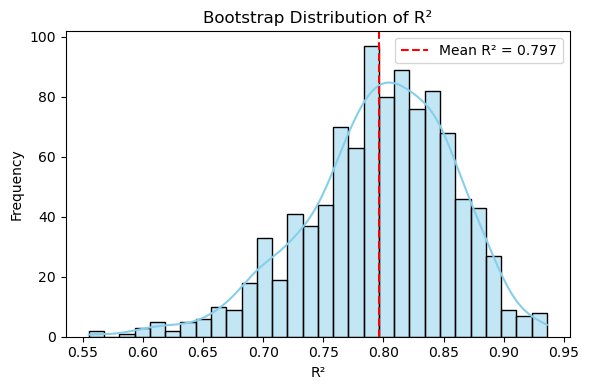

In [130]:
# Set random seed for reproducibility
np.random.seed(42)

# Define predictors and outcome
X = X_scaled_df[['x2', 'x7', 'x8']]

# Initialize storage
B = 1000  # Number of bootstrap samples
boot_coefs = []
boot_r2 = []

# Bootstrap loop
for _ in range(B):
    # Sample with replacement
    indices = np.random.choice(len(X), size=len(X), replace=True)
    X_boot = X.iloc[indices]
    y_boot = y.iloc[indices]
    
    # Fit model
    X_boot_const = sm.add_constant(X_boot)
    model = sm.OLS(y_boot, X_boot_const).fit()
    
    # Store coefficients
    boot_coefs.append(model.params.values)
    
    # Store R²
    y_pred = model.predict(X_boot_const)
    boot_r2.append(r2_score(y_boot, y_pred))

# Convert to DataFrame
coef_df = pd.DataFrame(boot_coefs, columns=['Intercept', 'x2', 'x7', 'x8'])
r2_series = pd.Series(boot_r2)

# ------------------------------
# Plot coefficient distributions
# ------------------------------
coef_df.hist(bins=30, figsize=(10, 6), layout=(2, 2), edgecolor='black')
plt.suptitle('Bootstrap Coefficient Distributions')
plt.tight_layout()
plt.show()

# ------------------------------
# Plot R² distribution
# ------------------------------
plt.figure(figsize=(6, 4))
sns.histplot(r2_series, bins=30, kde=True, color='skyblue', edgecolor='black')
plt.axvline(r2_series.mean(), color='red', linestyle='--', label=f'Mean R² = {r2_series.mean():.3f}')
plt.title('Bootstrap Distribution of R²')
plt.xlabel('R²')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

In [135]:
# Compute 95% CI for each coefficient
coef_ci = coef_df.quantile([0.025, 0.975])
coef_means = coef_df.mean()

print("95% Confidence Intervals, Midpoints, and Means for Coefficients:\n")
for col in coef_df.columns:
    lower, upper = coef_ci[col].values
    midpoint = (lower + upper) / 2
    mean = coef_means[col]
    print(f"{col:>9}:  CI = ({lower:.4f}, {upper:.4f})   Midpoint = {midpoint:.4f}   Mean = {mean:.4f}")

# Compute 95% CI, midpoint, and mean for R²
r2_lower = np.percentile(r2_series, 2.5)
r2_upper = np.percentile(r2_series, 97.5)
r2_midpoint = (r2_lower + r2_upper) / 2
r2_mean = r2_series.mean()

print("\nR² Summary:")
print(f"R²: CI = ({r2_lower:.4f}, {r2_upper:.4f})   Midpoint = {r2_midpoint:.4f}   Mean = {r2_mean:.4f}")

95% Confidence Intervals, Midpoints, and Means for Coefficients:

Intercept:  CI = (6.3489, 7.6086)   Midpoint = 6.9788   Mean = 6.9664
       x2:  CI = (1.2638, 2.2678)   Midpoint = 1.7658   Mean = 1.7834
       x7:  CI = (0.1679, 1.8298)   Midpoint = 0.9988   Mean = 1.0535
       x8:  CI = (-2.4239, -0.8950)   Midpoint = -1.6594   Mean = -1.6932

R² Summary:
R²: CI = (0.6617, 0.8963)   Midpoint = 0.7790   Mean = 0.7965


Compared to our subset model performance, the midpoint estimates for our three coefficients and r-squared value are incredibly similar, suggesting our model is stable in the presence of new data subsets from the same population. The bootstrap r-squared mean is 0.797, very similar to the subset r-squared of 0.786. The subset model coefficients of 6.96, 1.77, 1.06 and -1.71 (for the intercept, x2, x7 and x8 respectively), are all very similar to our bootstrap coefficient estimates of 6.97, 1.78, 1.05 and -1.69 respectively. We can also see that the bootstrap sampling has very similar 95% confidence intervals for all coefficients, albeit the bootstrap sample ranges are slightly narrowed due to the confidence gained from having more N in the dataset. Overall, the bootstrap sampling process has given us the added insight of what coefficient estimates we could expect across the full 95% confidence interval, and it also has established confidence that our model will be able to withstand different data samples from our population of NFL teams. 

#### Press Statistic

To further evaluate the model's predictive capability we can calculate and examine the PRESS statistic. This statistic is the prediction sum of squares, meaning it analytically simulates leave-one-out cross-validation for linear regression. This gives us a total squared error that we'd get if we had fit the model excluding each observation one at a timer and predicted it. This effectively simulates how the model will behave on new, unseen data. In general we can not expect the PRESS RMSE to be lower than the RMSE obtained from the model derived from the training data, but when comparing across multiple models, the one with the lower PRESS RMSE will be a better predictor overall. 

In [145]:
# Residuals and leverage values
residuals = subset_model.resid
leverage = subset_model.get_influence().hat_matrix_diag

# Compute PRESS: sum of squared leave-one-out residuals
press = np.sum((residuals / (1 - leverage))**2)

# Compute RMSE from PRESS
press_rmse = np.sqrt(press / len(residuals))


# Get predictions on the full dataset
y_pred = subset_model.fittedvalues
# Calculate RMSE
rmse_actual = np.sqrt(mean_squared_error(y, y_pred))

print(f"Model RMSE on Training Data: {rmse_actual:.4f}")
print(f"PRESS: {press:.4f}")
print(f"PRESS RMSE: {press_rmse:.4f}")

Model RMSE on Training Data: 1.5815
PRESS: 87.6946
PRESS RMSE: 1.7697


Our training data RMSE is 1.58, meaning on average the model misses actual win totals by 1.58 wins on the data it trained on. The PRESS RMSE of 1.77 suggests that on average, if we apply the model to a new NFL team not in the training set, the prediction would likely miss by ~1.77 wins. The small increase between both the training RMSE and PRESS RMSE suggests that our model is not overfitting, and than it is stable and generalizable. Since wins are whole numbers, both models will likely have the same ~2 win error, so it's predictability on new data is robust. 